# Missions

### Contexte : Nous souhaitons développer un algorithme permettant de détecter les faux billets. Pour cela, nous nous servirons des données caractéristiques des vrais billets afin de faire la distinction entre le vrai et le faux. Les données comportent 1000 vrais billets et 500 faux.

## 1) Analyse descriptive

A faire :

*   Répartition des dimensions des billets
*   Nombre de vrais/ faux billets...etc



## 2) Algorithme

L'algorithme doit utiliser un fichier contenant les dimensions de plusieurs billets ET de déterminer le type de chacun d'eux, A PARTIR DES SEULES DIMENSIONS

Utiliser 2 méthode de prédiction :

### a) Une régression logistique "classique"

### b) Un Kmeans

### c) Analyser les nombres de faux positifs et faux négatifs via une matrice de confusion

- Pour la méthode de régression logistique
- Pour la méthode de Kmean

# Projet

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Librairies traitement de données:
import numpy as np
import pandas as pd
import math

# Librairies graphiques:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# Librairies d'analyses:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import t, shapiro

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model, metrics, neighbors, preprocessing, decomposition, cluster
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

#Warning
import warnings
warnings.filterwarnings('ignore')

# Préparation des données

In [ ]:
billets = pd.read_csv('/content/drive/MyDrive/Openclassrooms/Colab Notebooks/Projet 10/Données de base/billets.csv', sep=";")
billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [ ]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


**Nous constatons :**


*   Que 37 valeurs sont manquantes dans la colonne "Margin low".
*   Qu'il n'y a pas d'anomalies sur le type des données.

## IMPORTANT

Puisque nous aurons besoin d'avoir des données précises pour distinguer les vrais des faux billets, il sera nécessaire de séparer ces 2 catégories de données au préalable.





On vérifie la présence de doublons.

In [ ]:
billets.duplicated().sum()

0

Il y a 0 doublons.

### Jeu de donnée de test

In [ ]:
billets_production = pd.read_csv('/content/drive/MyDrive/Openclassrooms/Colab Notebooks/Projet 10/Données de base/billets_production.csv')
billets_production

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [ ]:
billets_production.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      5 non-null      float64
 1   height_left   5 non-null      float64
 2   height_right  5 non-null      float64
 3   margin_low    5 non-null      float64
 4   margin_up     5 non-null      float64
 5   length        5 non-null      float64
 6   id            5 non-null      object 
dtypes: float64(6), object(1)
memory usage: 408.0+ bytes


## 1) Analyse descriptive

## Les variables

*   length : la longueur du billet (en mm)
*   height_left : la hauteur du billet (mesurée sur le côté gauche, en
mm)

*   height_right : la hauteur du billet (mesurée sur le côté droit, en mm)
*   margin_up : la marge entre le bord supérieur du billet et l'image de
celui-ci (en mm)

*   margin_low : la marge entre le bord inférieur du billet et l'image de
celui-ci (en mm)
*   diagonal : la diagonale du billet (en mm)







In [ ]:
billets_True = billets[billets["is_genuine"] ==True]
billets_True


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
995,True,171.66,103.92,103.47,4.26,2.83,113.20
996,True,172.16,103.72,103.61,4.30,2.72,113.51
997,True,171.78,103.38,104.22,4.23,3.07,113.77
998,True,171.44,103.96,103.92,3.68,2.89,113.21


On trouve bien les 1000 vrais billets comme attendus.

In [ ]:
# On décrit les données avec describe, puis on les transpose pour plus de clarté.

billets_True.describe().T

,count,mean,std,min,25%,50%,75%,max
diagonal,1000.0,171.987080,0.300441,171.04,171.790,171.990,172.20,172.92
height_left,1000.0,103.949130,0.300231,103.14,103.740,103.950,104.14,104.86
height_right,1000.0,103.808650,0.291570,102.82,103.610,103.810,104.00,104.95
margin_low,971.0,4.116097,0.319124,2.98,3.905,4.110,4.34,5.04
margin_up,1000.0,3.052130,0.186340,2.27,2.930,3.050,3.18,3.74
length,1000.0,113.202430,0.359552,111.76,112.950,113.205,113.46,114.44


In [ ]:
billets_True.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      29
margin_up        0
length           0
dtype: int64

Les vrais billets comportent 29 valeurs manquantes dans la colonne margin low.

In [ ]:
billets_Fake = billets[billets["is_genuine"] ==False]
billets_Fake

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1000,False,172.28,103.95,103.91,4.78,3.31,111.40
1001,False,171.92,103.86,104.30,4.96,3.13,111.29
1002,False,171.59,104.14,104.38,4.97,3.47,111.22
1003,False,172.02,104.33,104.33,5.19,3.21,111.99
1004,False,172.55,104.25,104.23,5.60,3.13,111.72
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [ ]:
billets_Fake.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      8
margin_up       0
length          0
dtype: int64

On trouve bien les 500 faux billets comme attendus. Il reste des valeurs manquantes à traiter

* On crée un jeu de données sans nan pour s'en servir plus tard au moment de la régression.

In [ ]:
billets_sans_nan = billets.dropna()
billets_sans_nan.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [ ]:
billets_sans_nan.shape

(1463, 7)

* On crée un jeu de données contenant tout les nan pour les compléter plus tard après avoir entraîné le modèle de régression linéaire.

In [ ]:
# Dataframe ne contenant que les valeurs manquantes :

df_billets_nan = billets.loc[(billets['margin_low'].isna()),:]
df_billets_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, 72 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    37 non-null     bool   
 1   diagonal      37 non-null     float64
 2   height_left   37 non-null     float64
 3   height_right  37 non-null     float64
 4   margin_low    0 non-null      float64
 5   margin_up     37 non-null     float64
 6   length        37 non-null     float64
dtypes: bool(1), float64(6)
memory usage: 2.1 KB


### a) Les données suivent-elles une loi normale ?

Nous séparons chaque variable, pour pouvoir vérifier si elles suivent chacune une loi normale.

In [ ]:
billets_True_diagonal = billets_True["diagonal"]
billets_Fake_diagonal = billets_Fake["diagonal"]

billets_True_height_left = billets_True["height_left"]
billets_Fake_height_left = billets_Fake["height_left"]

billets_True_height_right = billets_True["height_right"]
billets_Fake_height_right = billets_Fake["height_right"]

billets_True_margin_low = billets_True["margin_low"]
billets_Fake_margin_low = billets_Fake["margin_low"]

billets_True_margin_up = billets_True["margin_up"]
billets_Fake_margin_up = billets_Fake["margin_up"]

billets_True_length = billets_True["length"]
billets_Fake_length = billets_True["length"]

i) Variable "diagonal"

[Text(0.5, 1.0, 'billets_True_diagonal')]

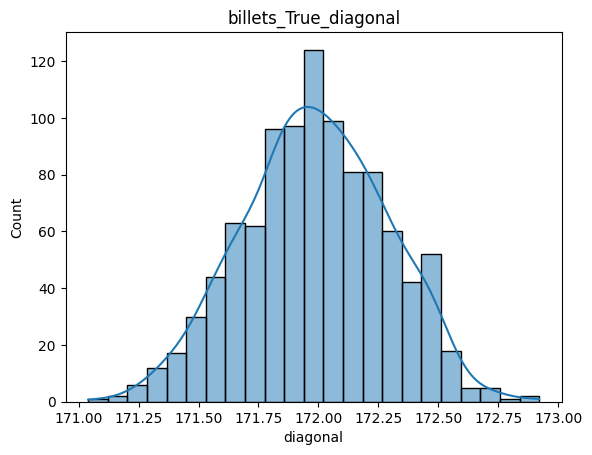

In [ ]:
# Méthode avec seaborn

sns.histplot(billets_True_diagonal, kde=True).set(title='billets_True_diagonal')

[Text(0.5, 1.0, 'billets_Fake_diagonal')]

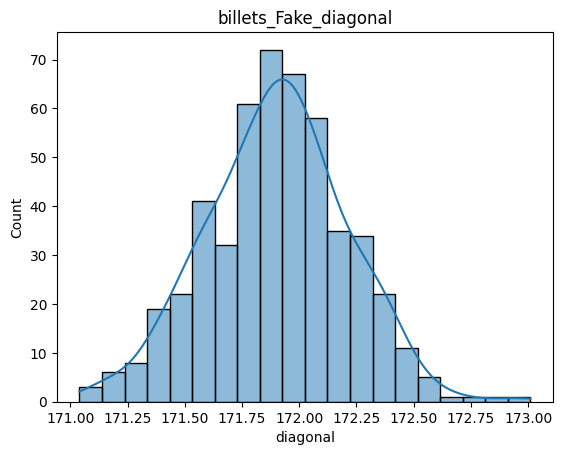

In [ ]:
# Méthode avec seaborn

sns.histplot(billets_Fake_diagonal, kde=True).set(title='billets_Fake_diagonal')

# Méthode avec matplotlib

from scipy.stats import norm

# Figure

fig = go.Figure()

# Courbe de Gauss des vrais billets

xv =np.linspace(171,173)
mean_v = np.mean(billets_True_diagonal)
std_v = np.std(billets_True_diagonal)
yv = norm.pdf(xv, mean_v, std_)*50
fig.addtrace(go.scatter(x=xv, y=yv, anme="Courbe de Gauss Vrai billet"))

# Courbe de Gauss des faux billets

xv =np.linspace(171,173)
mean_v = np.mean(billets_Fake_diagonal)
std_v = np.std(billets_Fake_diagonal)
yv = norm.pdf(xv, mean_v, std_)*50
fig.addtrace(go.scatter(x=xv, y=yv, anme="Courbe de Gauss Vrai billet"))

ii) billet_height_left

[Text(0.5, 1.0, 'billets_True_height_left')]

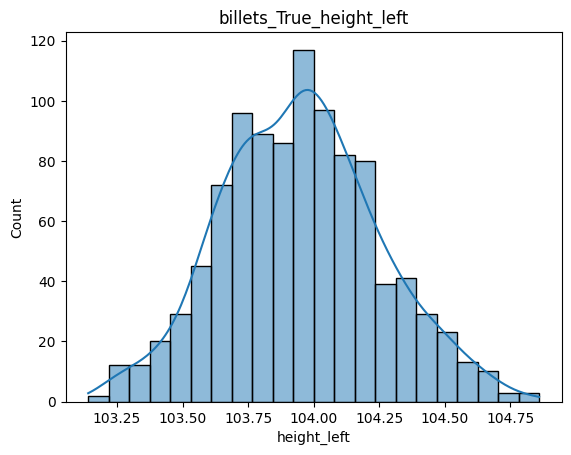

In [ ]:
# Méthode avec seaborn

sns.histplot(billets_True_height_left, kde=True).set(title='billets_True_height_left')


[Text(0.5, 1.0, 'billets_Fake_height_left')]

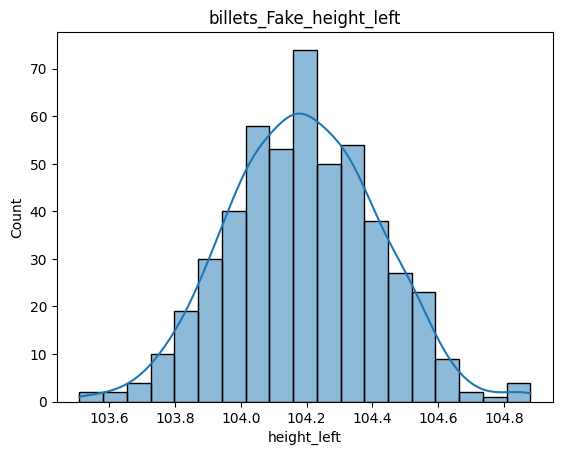

In [ ]:
# Méthode avec seaborn

sns.histplot(billets_Fake_height_left, kde=True).set(title='billets_Fake_height_left')

iii) billet_height_right

[Text(0.5, 1.0, 'billets_True_height_right')]

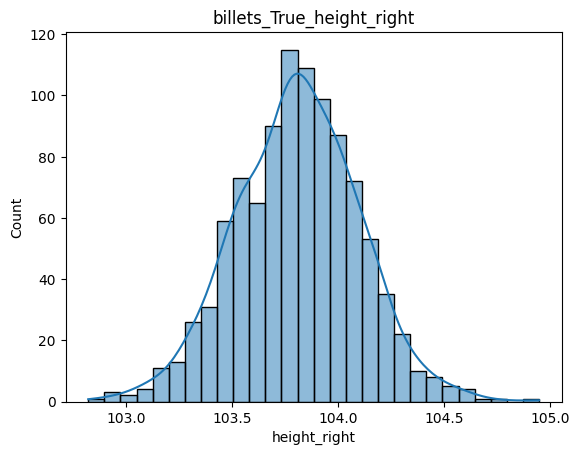

In [ ]:
# Méthode avec seaborn

sns.histplot(billets_True_height_right, kde=True).set(title='billets_True_height_right')

[Text(0.5, 1.0, 'billets_Fake_height_right')]

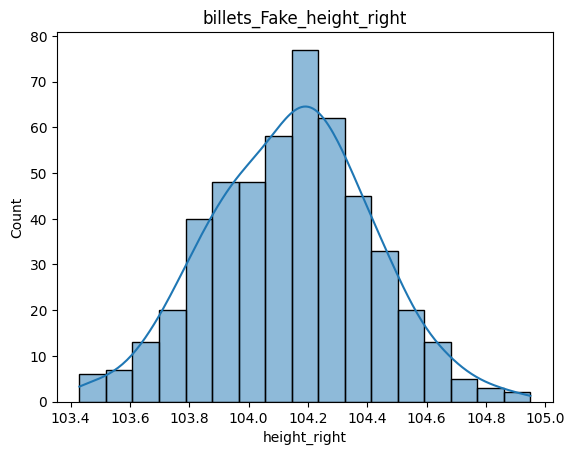

In [ ]:
sns.histplot(billets_Fake_height_right, kde=True).set(title='billets_Fake_height_right')

iiii) billet_margin_low




[Text(0.5, 1.0, 'billets_True_margin_low')]

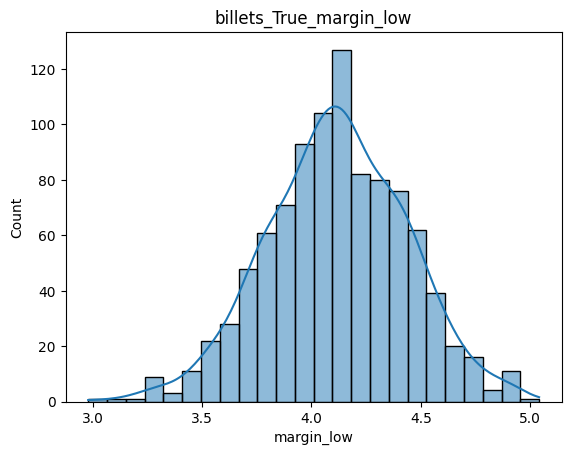

In [ ]:
# Méthode avec seaborn

sns.histplot(billets_True_margin_low, kde=True).set(title='billets_True_margin_low')

[Text(0.5, 1.0, 'billets_Fake_margin_low')]

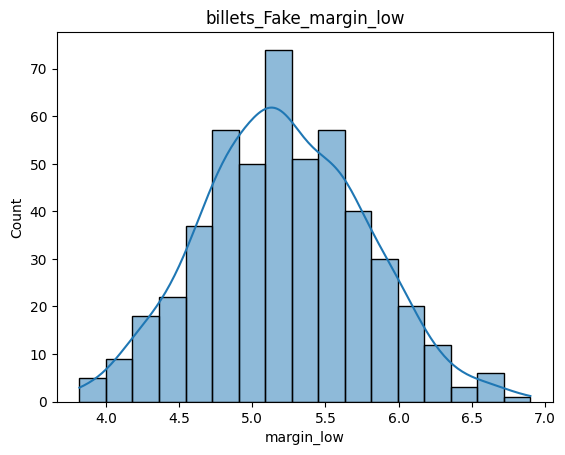

In [ ]:
sns.histplot(billets_Fake_margin_low, kde=True).set(title='billets_Fake_margin_low')

iiiii) billet_margin_up

[Text(0.5, 1.0, 'billets_True_margin_up')]

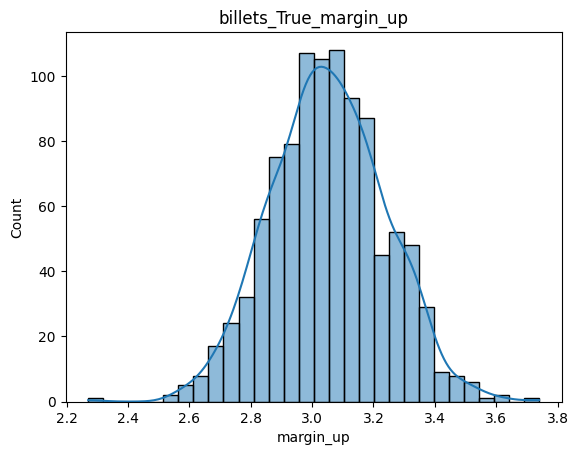

In [ ]:
# Méthode avec seaborn

sns.histplot(billets_True_margin_up, kde=True).set(title='billets_True_margin_up')

[Text(0.5, 1.0, 'billets_Fake_margin_up')]

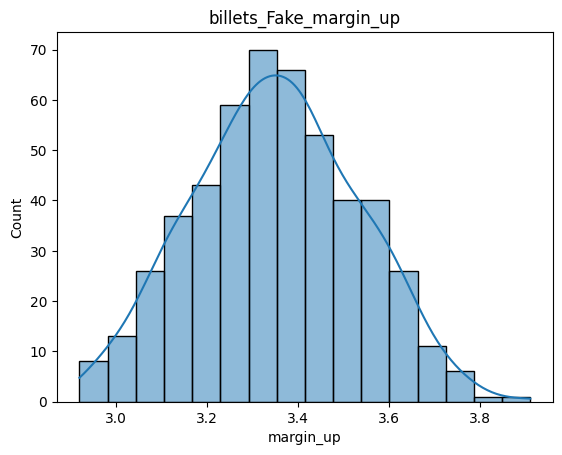

In [ ]:
sns.histplot(billets_Fake_margin_up, kde=True).set(title='billets_Fake_margin_up')

iiiiii) billet_length

[Text(0.5, 1.0, 'billets_True_length')]

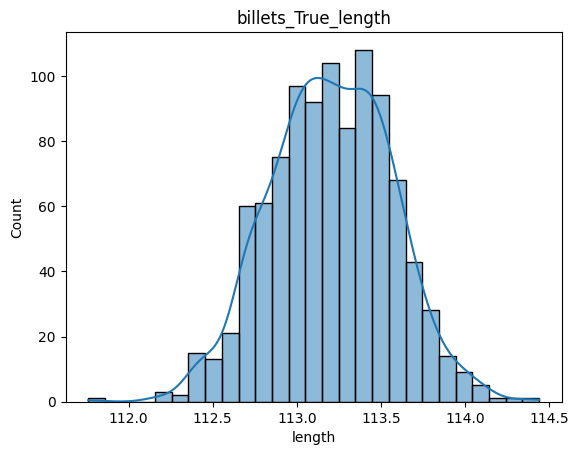

In [ ]:
# Méthode avec seaborn

sns.histplot(billets_True_length, kde=True).set(title='billets_True_length')

[Text(0.5, 1.0, 'billets_Fake_length')]

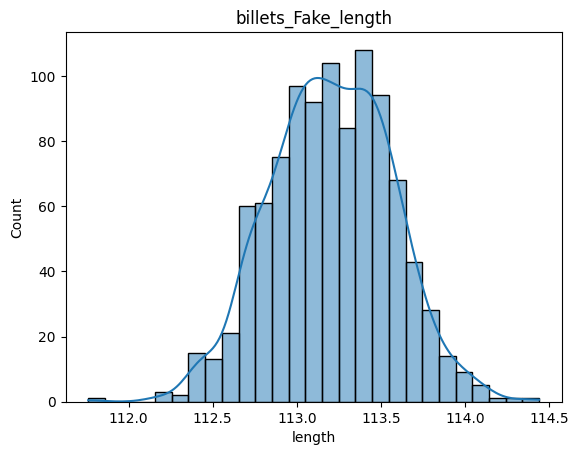

In [ ]:
sns.histplot(billets_Fake_length, kde=True).set(title='billets_Fake_length', )


Les distributions des variables sont symétriques et devraient donc suivre une loi normale.

In [ ]:
billets_True.describe().T

,count,mean,std,min,25%,50%,75%,max
diagonal,1000.0,171.987080,0.300441,171.04,171.790,171.990,172.20,172.92
height_left,1000.0,103.949130,0.300231,103.14,103.740,103.950,104.14,104.86
height_right,1000.0,103.808650,0.291570,102.82,103.610,103.810,104.00,104.95
margin_low,971.0,4.116097,0.319124,2.98,3.905,4.110,4.34,5.04
margin_up,1000.0,3.052130,0.186340,2.27,2.930,3.050,3.18,3.74
length,1000.0,113.202430,0.359552,111.76,112.950,113.205,113.46,114.44


In [ ]:
billets_Fake.describe().T

,count,mean,std,min,25%,50%,75%,max
diagonal,500.0,171.901160,0.306861,171.04,171.69,171.91,172.0925,173.01
height_left,500.0,104.190340,0.223758,103.51,104.04,104.18,104.3325,104.88
height_right,500.0,104.143620,0.270878,103.43,103.95,104.16,104.3200,104.95
margin_low,492.0,5.215935,0.553531,3.82,4.84,5.19,5.5925,6.90
margin_up,500.0,3.350160,0.180498,2.92,3.22,3.35,3.4725,3.91
length,500.0,111.630640,0.615543,109.49,111.20,111.63,112.0300,113.85


**Si graphiquement les variables suivent une loi normale, alors leur moyenne doit être proche de la médiane. Vérifions:**

**Pour billets_True :**

diagonal : Ok

height_left : Ok

height_right : Ok

margin_up : Ok

margin_low : Ok

lenght : Ok

**Pour billets_Fake :**

diagonal : Ok

height_left : Ok

height_right : Ok

margin_up : Ok

margin_low : Ok

lenght : Ok


##b) Matrice de corrélation

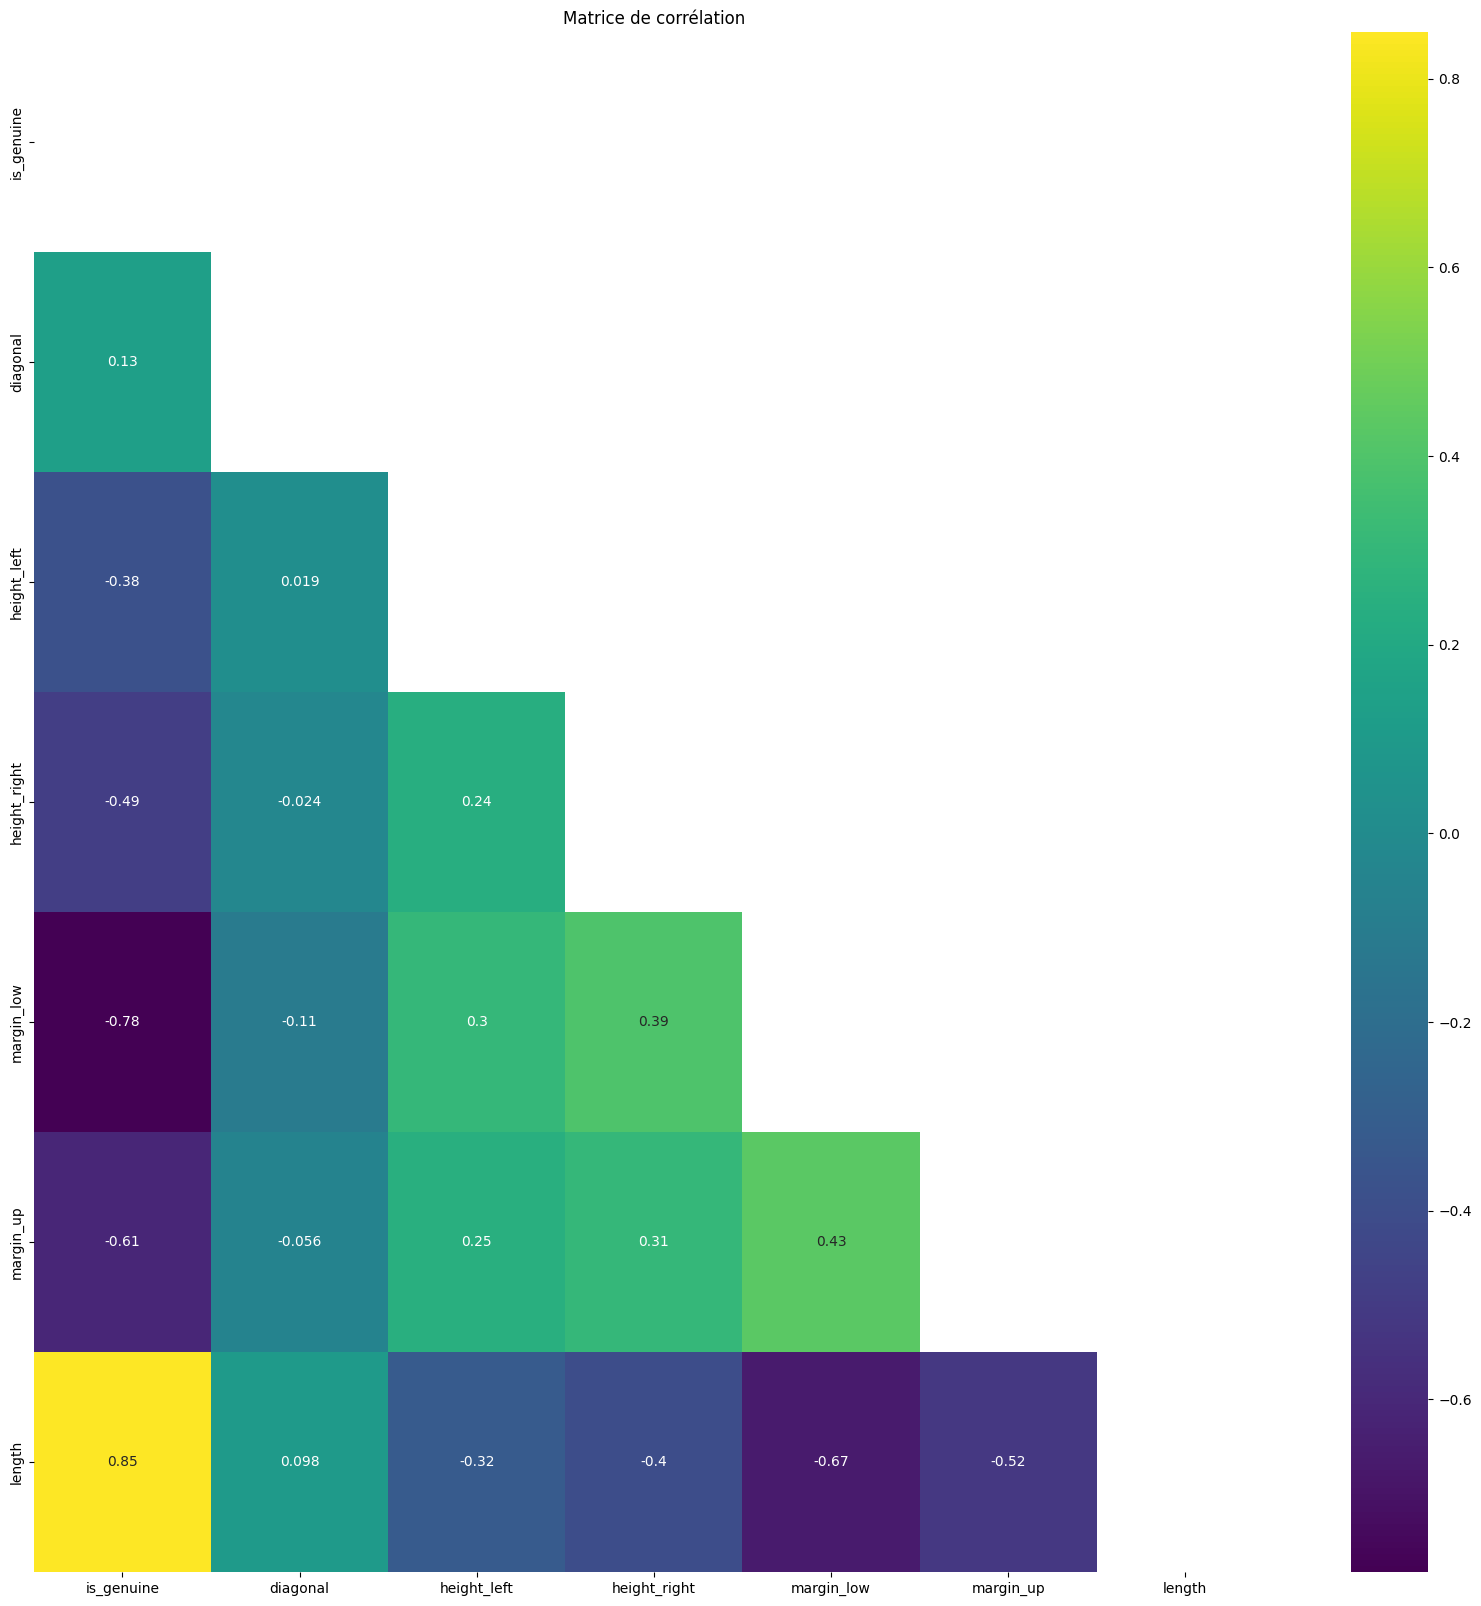

In [ ]:
# Matrice de corrélation
matrice_correlation = billets.corr()
# On ajoute cette variable pour afficher uniquement le triangle inférieur de la heatmap (et éviter d'afficher les doublons de valeurs)
matrix = np.triu(matrice_correlation)
# Visualisation de la matrice avec une heatmap
plt.figure(figsize=(20,20))
sns.heatmap(matrice_correlation, cmap ='viridis', annot=True, mask=matrix)
plt.title('Matrice de corrélation')
plt.show()

## c) Nuage de points

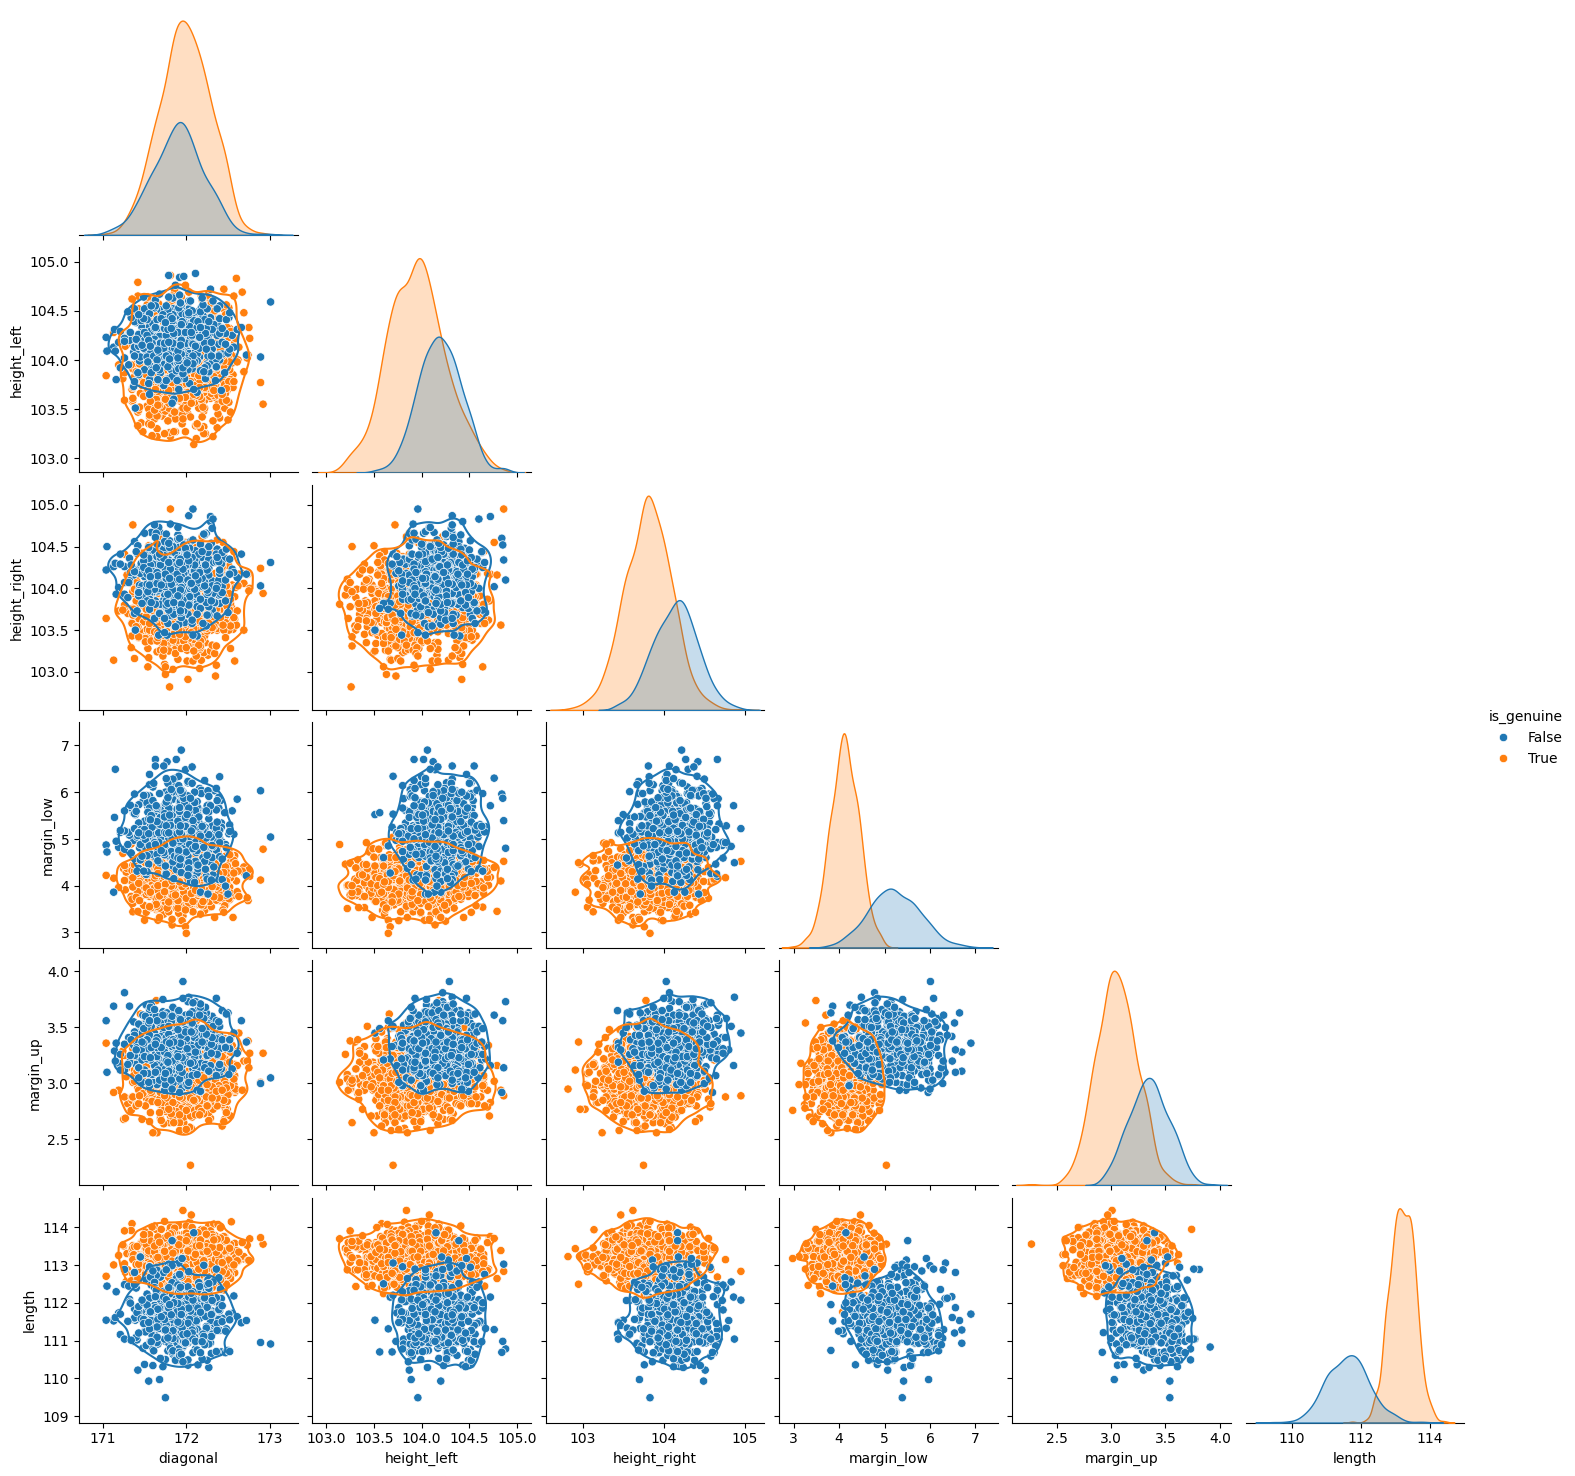

In [ ]:
# Pour la visualisation, nous la simplifions avec corner=True en n'ajoutant pas d'axes au triangle supérieur (hors diagonale) de la grille pour obtenir un graphique en "coin", plus lisible.

g= sns.pairplot(billets, hue="is_genuine", corner=True)
g.map_lower(sns.kdeplot, levels=2, color='.2')

On peut remarquer :



*   D'après les graphiques de distribution, les variables permettant de mieux distinguer les vrais des faux billets seraient margin_low et lenght.
*   Les valeurs des vrais billets sont plus resserrées tandis que celles des faux sont plus dispersées.
* Pour les nuages de points peut nettement distinguer 2 groupes , les vrais billets et les faux.



# Régression linéaire multiple

In [ ]:
# Régression linéaire multiple
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=billets).fit()
reg_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 24 Jul 2024   Prob (F-statistic):          2.60e-202
Time:                        21:38:52   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382      0.017       4.055      41.935
diagonal        -0.1111      0.041     -2.680      0.007      -0.192      -0.030
height_left      0.1841      0.045      4.113      0.000       0.096       0.272
height_right     0.2571      0.043      5.978      0.000       0.173       0.342
margin_up        0.2562      0.064      3.980      0.000       0.130       0.382
length          -0.4091      0.018    -22.627      0.000      -0.445      -0.374
==============================================================================
Omnibus:                       73.627   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.862
Skew:                           0.482   Prob(JB):                     1.53e-21
Kurtosis:                       3.801   Cond. No.                     1.94e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Le R2 est de 0.617, ce qui indique que la somme des carrés expliqués est plus importantes que la somme des carrés totaux. Le modèle est relativement fiable mais pourrait être meilleur, en se rapprochant de R2 = 1.

Il y a bien une relation linéaire entre margin low et les autres variables du modèle.

## Retirez les variables non significatives

In [ ]:
#le code que j'ai utilisé du cours d'OpenClassroom (TP 2 : Pratiquez la régression linéaire multiple sur le jeu de données de l'ozone)

def backward_selected(data, response):

    remaining = set(data._get_numeric_data().columns)
    if response in remaining:
        remaining.remove(response)
    cond = True

    while remaining and cond:
        formula = "{} ~ {} + 1".format(response,' + '.join(remaining))
        print('_______________________________')
        print(formula)
        model = smf.ols(formula, data).fit()
        score = model.pvalues[1:]
        toRemove = score[score == score.max()]
        if toRemove.values > 0.05:
            print('remove', toRemove.index[0], '(p-value :', round(toRemove.values[0],3), ')')
            remaining.remove(toRemove.index[0])
        else:
            cond = False
            print('is the final model !')
        print('')
    print(model.summary())

    return model

In [ ]:
# On élimine les variables non significatives (dont la p-value est supérieur à 0.5)

columns = ['margin_low','diagonal', 'height_left', 'height_right', 'margin_up', 'length']
regression_backward = backward_selected(billets_sans_nan[columns], 'margin_low')

_______________________________
margin_low ~ height_left + margin_up + height_right + length + diagonal + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 24 Jul 2024   Prob (F-statistic):          2.60e-202
Time:                        21:38:52   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]

Toutes les variables sont maintenant significatives avec une pvalue inférieur ou égale à 0.05.

Le 𝑅2 vaut environ 0.617, et le 𝑅2 ajusté est d'environ 0.615.

On va donc maintenant retirer les variables non significatives: 'diagonal','length','height_right','height_left', car ils ont une p-valeur > 0.05

In [ ]:
reg_multiple = smf.ols('margin_low ~ height_left + length + height_right + diagonal + margin_up', data=billets_sans_nan).fit()
print(reg_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 24 Jul 2024   Prob (F-statistic):          2.60e-202
Time:                        21:38:52   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

On peut donc utiliser ce modèle (avec les variables 'is_genuine' et 'margin_up') à des fins de prévision de la variable 'margin_low'.

Le 𝑅2 vaut environ 0.617, et le 𝑅2 ajusté est d'environ 0.616.

## Prédiction des valeurs manquantes par le résultat de la régression

In [ ]:
# On réalise une prédiction pour la colonne ['margin_low'] à partir de la régression linéaire sur les colonnes 'is_genuine' et 'margin_up'.
# Les données ont été sur les données qui ne contenaient pas les valeurs manquantes, pour plus de précision.

a_prevoir = df_billets_nan[['height_left','length','height_right','diagonal','margin_up']]

df_billets_nan['margin_low'] = reg_multiple.predict(a_prevoir)
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [ ]:
df_billets_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, 72 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    37 non-null     bool   
 1   diagonal      37 non-null     float64
 2   height_left   37 non-null     float64
 3   height_right  37 non-null     float64
 4   margin_low    37 non-null     float64
 5   margin_up     37 non-null     float64
 6   length        37 non-null     float64
dtypes: bool(1), float64(6)
memory usage: 2.1 KB


**On ajoute les valeurs manquantes dans le dataframe "billets"**

In [ ]:
billets_sans_nan.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [ ]:
billets_sans_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1463 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1463 non-null   bool   
 1   diagonal      1463 non-null   float64
 2   height_left   1463 non-null   float64
 3   height_right  1463 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1463 non-null   float64
 6   length        1463 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 81.4 KB


## Données complétées via la régression linéaire

In [ ]:
# Ajouter les lignes qui ont remplacé les valeurs nulles
df_billets_2 = pd.concat([billets_sans_nan,df_billets_nan])
df_billets_2.to_csv('billets_complete.csv')

In [ ]:
df_billets_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 0 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.5 KB


Il n'y a plus de valeurs manquantes dans la colonne margin_low

Analyse des résultats
Pour l'analyse de résultats, je commence une nouvelle régression linéaire avec les paramètres significatifs et les valeurs manquantes complétées:

In [ ]:
# Nouveau calcul de régression linéaire
reg_multi2 = smf.ols('margin_low ~ height_left + length + height_right + diagonal + margin_up', data=df_billets_2).fit()

In [ ]:
# Résultat
reg_multi2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             margin_low   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     280.0
Date:                Wed, 24 Jul 2024   Prob (F-statistic):          1.65e-211
Time:                        21:38:52   Log-Likelihood:                -1007.9
No. Observations:                1500   AIC:                             2028.
Df Residuals:                    1494   BIC:                             2060.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.427      2.439      0.015       4.504      41.486
height_left      0.1841      0.044      4.202      0.000       0.098       0.270
length          -0.4091      0.018    -23.203      0.000      -0.444      -0.375
height_right     0.2571      0.042      6.159      0.000       0.175       0.339
diagonal        -0.1111      0.040     -2.747      0.006      -0.190      -0.032
margin_up        0.2562      0.063      4.088      0.000       0.133       0.379
==============================================================================
Omnibus:                       80.605   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.966
Skew:                           0.488   Prob(JB):                     1.32e-24
Kurtosis:                       3.898   Cond. No.                     1.94e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Calculez les leviers:
On peut calculer les leviers et établis un seuil de levier pour savoir s'il y a des valeurs influentes et/ou atypiques.
Nous allons ici réaliser les tests à un niveau 𝛼=5 % :

alpha=0.05

Récupérons 𝑛 , le nombre d'individus de l'échantillon, et 𝑝 , le nombre de variables.

In [ ]:
n = df_billets_2.shape[0]
p = 3

Nous allons mener des analyses sur les valeurs atypiques et/ou influentes en travaillant sur un dataframe appelé analyses.

In [ ]:
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})
analyses['obs'] = analyses['obs'].astype('float')

On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de 2∗𝑝𝑛 .

In [ ]:
analyses['levier'] = reg_multi2.get_influence().hat_matrix_diag
seuil_levier = 2*p/n

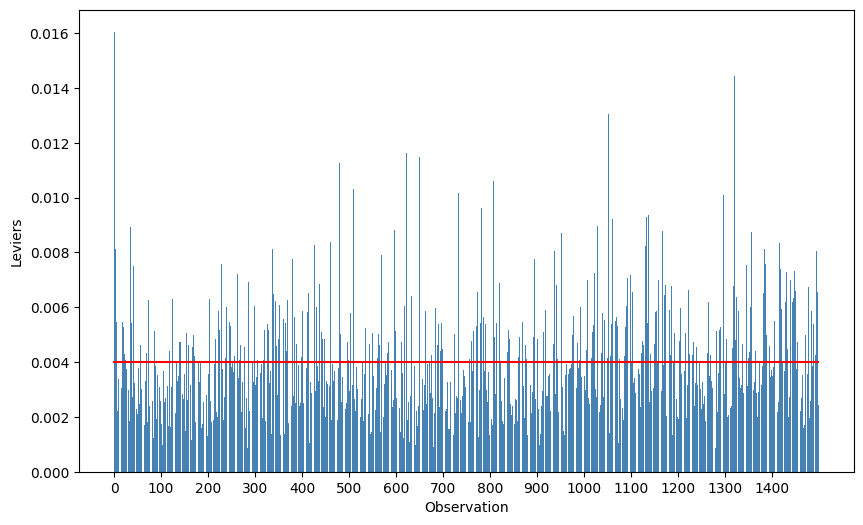

In [ ]:
# Visualisation
plt.figure(figsize=(10,6))
# Barplot des observations et leviers
plt.bar(analyses['obs'], analyses['levier'], color='steelblue')
plt.xticks(np.arange(0, 1500, step=100))
# Titres
plt.xlabel('Observation')
plt.ylabel('Leviers')
# Ligne de seuil_levier
plt.plot([0, 1500], [seuil_levier, seuil_levier], color='red')

plt.show()

In [ ]:
# Sélection des points où le leviers est supérieur au seuil
analyses.loc[analyses['levier'] > seuil_levier, :]

,obs,levier
0,1.0,0.016051
1,2.0,0.005839
2,3.0,0.008107
3,4.0,0.004323
4,5.0,0.005447
...,...,...
1493,1494.0,0.004248
1494,1495.0,0.005036
1495,1496.0,0.008044
1497,1498.0,0.006564


Pour sélectionner les points pour lesquels le levier est supérieur au seuil, on exécute la ligne suivante :

Calculez les résidus studentisés
Si l'on souhaite maintenant calculer les résidus studentisés, nous écrivons ceci, sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté :

In [ ]:
# On définit la valeur de alpha pour déterminer le seuil critique pour les résidus studentisés, ce qui permet d'identifier les points aberrants (outliers) dans les données de régression.

alpha = 0.05

In [ ]:
# Importation de l'outil
from scipy.stats import t, shapiro

# Calcul des résidus studentisés
analyses['rstudent'] = reg_multi2.get_influence().resid_studentized_internal
# Seuil est une loi de Student avec un degré de liberté égal à n-p-1
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

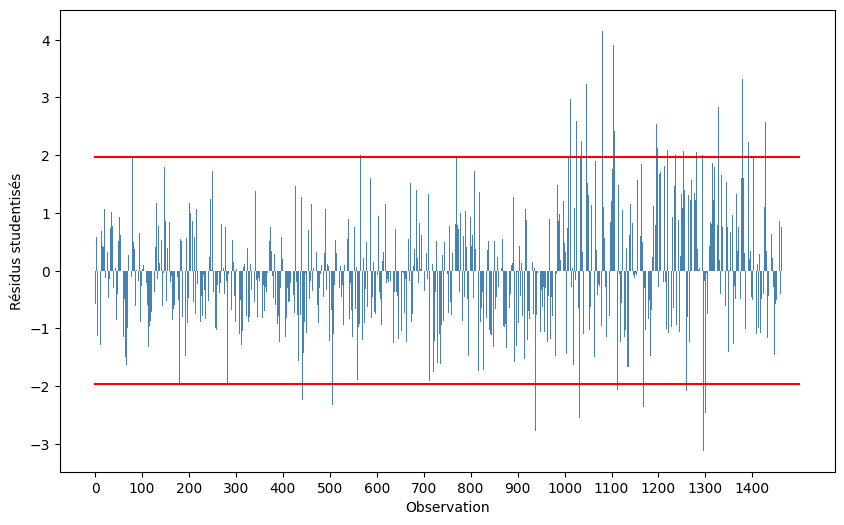

In [ ]:
# Visualisation des résidus studentisés
plt.figure(figsize=(10,6))

# Barplot des résidus
plt.bar(analyses['obs'], analyses['rstudent'], color='steelblue')
plt.xticks(np.arange(0, 1500, step=100))
# Titres
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
# Lignes des seuils
plt.plot([0, 1500], [seuil_rstudent, seuil_rstudent], color='red')
plt.plot([0, 1500], [-seuil_rstudent, -seuil_rstudent], color='red')

plt.show()

**Les points >2 et <-2 (au-delà des lignes rouges) sont considérés comme des outliers. Les résidus studentisés mettent ainsi en avant plusieurs outliers.**

**Déterminez la distance de Cook¶**

Elle nous sert à identifier les observations influentes dans notre modèle de régression. Elle permet de détecter les points de données qui ont un impact disproportionné sur les estimations des coefficients du modèle.

Pour trouver la distance de Cook, nous exécutons ceci :

In [ ]:
influence = reg_multi2.get_influence().summary_frame()

Le seuil de la distance de Cook est de n-p.

On peut détecter les observations influentes comme ceci :

**Hypothèse de Multicolinéarité**

In [ ]:
variables = reg_multi2.model.exog
[variance_inflation_factor(variables, i)
 for i in np.arange(1, variables.shape[1])]

[1.1452953155830756,
 1.5747645461870932,
 1.2292627049179954,
 1.0127902418532093,
 1.4035168315798585]

On observe que tous les coefficients VIF sont inférieurs à 10, il n'y a donc pas de problème de colinéarité pour la regression linéaire.

Test d'homoscédasticité:
On applique un test de Breusch Pagan pour tester l'homoscedasticité des résidus. L'hypothèse nulle est homoscédasticité(c'est-à-dire la constance de la variance) des résidus.

In [ ]:
reg_multi2.resid

0      -2.686765e-01
1      -3.689077e-01
2       2.740674e-01
3      -5.365802e-01
4      -5.374253e-01
            ...     
1303   -7.460699e-14
1315   -7.460699e-14
1347   -7.815970e-14
1435   -7.460699e-14
1438   -7.460699e-14
Length: 1500, dtype: float64

In [ ]:
reg_multi2.resid.mean()

1.372863304519948e-13

On observe que la moyenne des résidus est très proche de 0.

In [ ]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi2.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 3.530106669864376e-16


La p-valeur ici est inférieure à 5 %, on rejette l'hypothèse 𝐻0 selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

Représentez les résidus du modèle:

In [ ]:
# Testez la normalité des résidus:
shapiro(reg_multiple.resid)

ShapiroResult(statistic=0.9857882857322693, pvalue=8.540482210328548e-11)

L'hypothèse de normalité est remise en cause (p-value = 6.2e-06 < 0.05).

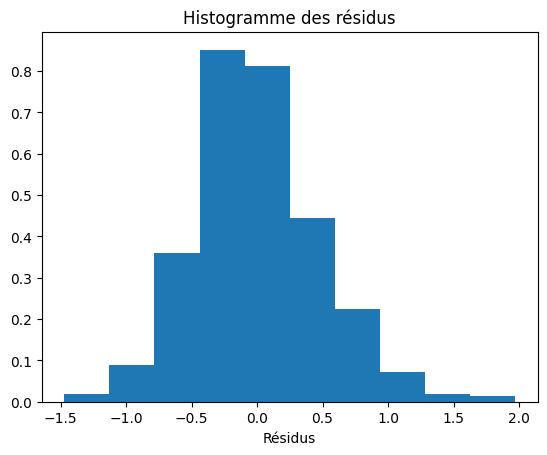

In [ ]:
residus = reg_multiple.resid
plt.hist(residus , density=True)
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
plt.show()

L'allure de l'histogramme est assez classique : centrée et à peu près symétrique.

La p-value est très inférieure à 0,05 et nous rejetons donc l'hypothèse H0, et donc la distribution normale des résidus. Cependant, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.

In [ ]:
columns = ['margin_low','diagonal', 'height_left', 'height_right', 'margin_up', 'length']
regression_backward = backward_selected(billets_sans_nan[columns], 'margin_low')

_______________________________
margin_low ~ height_left + margin_up + height_right + length + diagonal + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 24 Jul 2024   Prob (F-statistic):          2.60e-202
Time:                        21:39:05   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]

## 2) Algorithme

### a) Régression logistique

On élimine les valeurs manquantes de notre jeu de données.

In [ ]:
billets.dropna(inplace=True)
billets.shape

(1463, 7)

Note :

Avec Sklearn, on passera toujours par ces mêmes 3 étapes:


1 ) On définit le modèle
model = typedemodele(données)

2) On entraîne les données avec .fit().
model.fit(X, y)

Attention : Les données X et y doivent être présentent dans 2 tableau numpy distinct !

Ces tableaux doivent toujours avec 2 dimensions (un nombre de lignes et un nombre de colonnes , respectivement appelées nombre d'échantillons et nombre de features (les variables qui vont servir à l'entraînement).

Note : pour y, les features sont appelés target (c'est l'objectif de l'entraînement). Et il y a une cible, donc target est égal à 1.

3) On utilise ensuite la méthode .score pour évaluer le modèle. Ici on évalue la performance du modèle par rapport à l'exemple test.

model.score(X, y)

4) Puis on utilise la méthode .predict(X)

In [ ]:
import numpy as np

In [ ]:
billets.columns

Index(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'],
      dtype='object')

In [ ]:
# 1) On sépare nos données avant de commencer

# a)
X = billets[['diagonal', "height_left", "height_right", "margin_up"]]  # Variables indépendantes


# b)
# On ne doit garder qu'une seule colonne pour y.
y = billets['is_genuine']      # Variable dépendante


In [ ]:
# On doit avoir 2 dimensions pour X et 1 dimension pour y

print(X.ndim)
print(y.ndim)

2
1


In [ ]:
# 2 ) On réparti les données entre un jeu destiné à l'entraînement du modèle, et un jeu destiné au test du modèle. On choisit de prendre 80% de données pour l'entraînement et 20% pour le test.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# On vérifie que les données ont bien été séparées.

print('Train_set', X_train.shape)
print('Test_set', y_train.shape)

Train_set (1170, 4)
Test_set (1170,)


In [ ]:
 # 3) On intancie, on dit crée "l'environnement" pour faire la régression logistique.
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

# 4) On entraîne le modèle

model.fit(X_train, y_train)



LogisticRegression()

# On évalue la performance du modèle de classification

In [ ]:
# 5) On teste le modèle


# Si on teste les données avec les données d'entraînement, le résultat du test sera faussé. Nous allons comparer le résultat d'un test avec les données d'entraînement avec ceux d'un test avec des données non entraînées.
print("Train_score:", model.score(X_train, y_train))

# On teste le modèle avec des données qui n'ont pas été utilisées dans l'entraînement (car le modèle reconnaîtrait automatiquement les données, puisqu'il les connait)

print("Test_score:", model.score(X_test, y_test))


Train_score: 0.8606837606837607
Test_score: 0.8430034129692833


On remarque bien une différence entre les 2.

# Autre méthode d'évaluation de la performance du modèle : Le "classification report"

In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test, prediction))

On a ici une précision de 0.84.

# Représentation graphique de la précision du modèle

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=808).fit(X_train, y_train)

<Axes: ylabel='Count'>

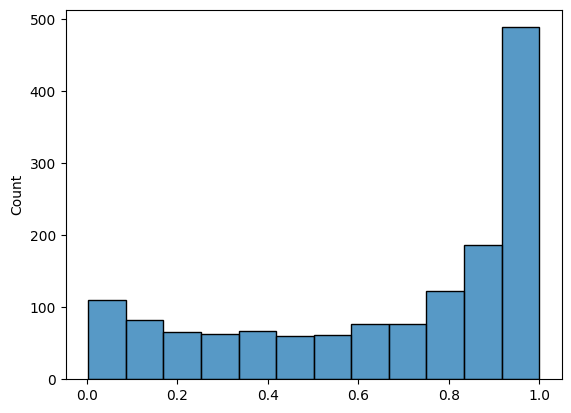

In [ ]:
model_proba = clf.predict_proba(X)[:,1]
import seaborn as sns
sns.histplot(model_proba)

Commentaire : Le modèle est assez fiable au niveau de ses prédictions, la plupart des prédictions ont une probabilité prochede 1.

# Vérification de la précision du modèle via une matrice de confusion

In [ ]:
X_test

,diagonal,height_left,height_right,margin_up
1208,171.96,104.38,103.82,3.32
178,171.79,104.57,104.04,3.15
281,171.99,103.90,104.21,3.07
561,172.25,103.71,103.97,3.00
891,172.16,103.63,103.59,3.38
...,...,...,...,...
1491,171.79,104.18,104.54,3.51
493,172.55,103.97,104.04,3.34
494,172.08,104.19,104.03,2.99
1080,172.23,103.83,104.29,3.47


In [ ]:
prediction = clf.predict(X_test)

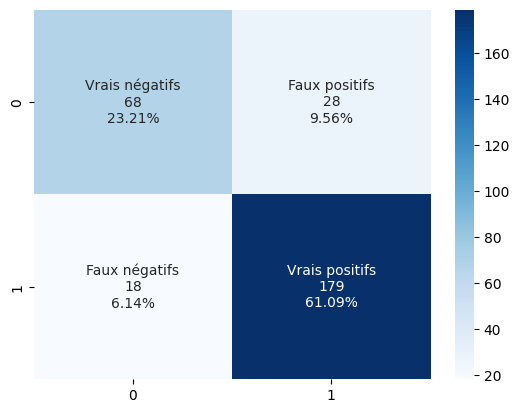

              precision    recall  f1-score   support

       False       0.79      0.71      0.75        96
        True       0.86      0.91      0.89       197

    accuracy                           0.84       293
   macro avg       0.83      0.81      0.82       293
weighted avg       0.84      0.84      0.84       293



In [ ]:
from sklearn.metrics import confusion_matrix

def matrice_confusion(a, b, nom_graphique):
    confusion_matrix = sklearn.metrics.confusion_matrix(a,b)
    group_names = ['Vrais négatifs','Faux positifs','Faux négatifs','Vrais positifs']
    group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrix.flatten()]
    group_percentages = [
        '{0:.2%}'.format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')
    #save_fig(nom_graphique)
    plt.show()

    classification = sklearn.metrics.classification_report(a,b)
    print(classification)

matrice_confusion(y_test, prediction, 'regression_logistique_matrice-confusion')

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, prediction)

array([[ 68,  28],
       [ 18, 179]])

Dans notre matrice de confusion, on a :  

*   81 Vrais négatifs : les négatifs qui sont bien prédits
*   172 Vrais positifs : les positifs qui sont bien prédits
* 17 faux négatifs : les négatifs mal prédits
* 30 faux positifs : les négatifs qui sont mal prédits



# Vérification de l'optimisation du modèle : la courbe ROC

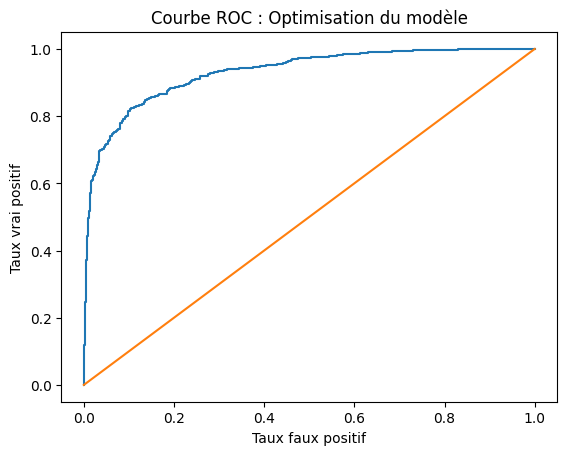

In [ ]:
from sklearn.metrics import roc_curve
tfp, tvp, thresholds = roc_curve(y, model_proba)

import matplotlib.pyplot as plt
plt.plot(tfp, tvp)
plt.xlabel("Taux faux positif")
plt.ylabel("Taux vrai positif")
plt.title("Courbe ROC : Optimisation du modèle")

axe_x = [0.0, 0.2, 0.4, 0.6, 0.8, 1]
axe_y = [0.0, 0.2, 0.4, 0.6, 0.8, 1]
plt.plot(axe_x, axe_y)


Plus le coin est situé en haut à gauche, plus le modèle est optimisé. Le modèle est perfectible mais n'est pas mauvais.

## b) Méthode des Kmeans (méthode de classification)

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.cluster import KMeans

In [ ]:
# On extrait X :
X = billets.values
X

array([[True, 171.81, 104.86, ..., 4.52, 2.89, 112.83],
       [True, 171.46, 103.36, ..., 3.77, 2.99, 113.09],
       [True, 172.69, 104.48, ..., 4.4, 2.94, 113.16],
       ...,
       [False, 171.8, 104.01, ..., 5.51, 3.36, 111.95],
       [False, 172.06, 104.28, ..., 5.17, 3.46, 112.25],
       [False, 171.47, 104.15, ..., 4.63, 3.37, 112.07]], dtype=object)

In [ ]:
# On peut le transformer en DataFrame :
X_df = pd.DataFrame(X)

# Cela permet d'appliquer la méthode .head :
X_df.head()

,0,1,2,3,4,5,6
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.5,4.4,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [ ]:
# On élimine les colonnes non numériques (Indexe 11 et 12) et celles comportant des dates (Indexe 14)

X_df = X_df.drop(X_df.columns[[0]], axis=1)
X_df

,1,2,3,4,5,6
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.5,4.4,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...
1458,171.75,104.38,104.17,4.42,3.09,111.28
1459,172.19,104.63,104.44,5.27,3.37,110.97
1460,171.8,104.01,104.12,5.51,3.36,111.95
1461,172.06,104.28,104.06,5.17,3.46,112.25


In [ ]:
# On vérifie si les données ne comportent pas de valeurs manquantes :

X_df.isna().sum()

1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64

Il n'y a pas de valeurs manquantes. Nous pouvons continuer.

# Méthode des K-means

## Préparation des données : Standardisation des données

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X_df)
x_scaled

array([[-0.48859357,  2.76680735,  3.17376615,  0.05128623, -1.13698239,
         0.17784229],
       [-1.63480853, -2.24148961, -0.80685073, -1.07893701, -0.7048056 ,
         0.47569209],
       [ 2.39331832,  1.49803879, -1.30057066, -0.12954949, -0.92089399,
         0.55588243],
       ...,
       [-0.52134257, -0.07122759,  0.61259405,  1.5431809 ,  0.89424851,
        -0.83026476],
       [ 0.3301314 ,  0.83026586,  0.42744908,  1.03081304,  1.32642529,
        -0.4865919 ],
       [-1.60205953,  0.39621346, -0.31313081,  0.2170523 ,  0.93746618,
        -0.69279562]])

Nous allons effectuer un clustering avec l'algorithme du k-means.

## A ) On fixe un nombre spécific de cluster, pour commencer.

note : le nombre de cluster est connu à l'avance (2) : soit un billet est vrai, soit il est faux.

Testons tout d'abord avec un nombre défini de clusters.

On instancie notre estimateur:

In [ ]:
kmeans = KMeans(n_clusters=2)

On l'entraine avec .fit() :

In [ ]:
kmeans.fit(X_df)



# note de rappel (en cas de bug) : /usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning warnings.warn(

KMeans(n_clusters=2)

On peut calculer son inertie :

In [ ]:
kmeans.inertia_

948.7020346072871

# Utilisation de la méthode du coude

Si tout fonctionne correctement, le nombre de cluster optimal sera de 2.

Passons à la méthode du coude.

* 1) On défini d'abord une liste vide pour stocker nos inerties:
* 2) On défini ensuite la liste du nombre de clusters que l'on veut tester:
* 3) Ensuite, pour chaque valeur de k (avec une boucle for), on entraine un k-means spécifique et on stocke son inertie :
Pour chaque nombre de clusters :
* a) On instancie un k-means pour k clusters
* b) On entraine le modèle avec .fit()
* c) On enregistre l'inertie obtenue

In [ ]:
1# Une liste vide pour enregistrer les inerties :
liste_inertie = [ ]
k_liste_cluster = range(1, 10)
for k in k_liste_cluster :
    model = KMeans(n_clusters=k, n_init=10).fit(X_df)
    liste_inertie.append(model.inertia_)

In [ ]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1463 entries, 0 to 1462
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   1       1463 non-null   object
 1   2       1463 non-null   object
 2   3       1463 non-null   object
 3   4       1463 non-null   object
 4   5       1463 non-null   object
 5   6       1463 non-null   object
dtypes: object(6)
memory usage: 68.7+ KB


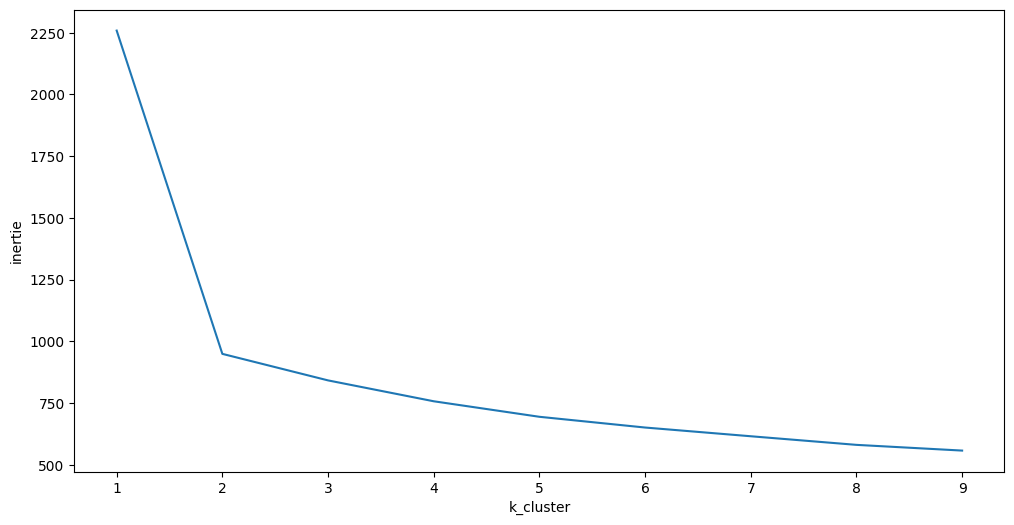

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("inertie")
ax.set_xlabel("k_cluster")

ax = plt.plot(k_liste_cluster, liste_inertie)

Nous trouvons bien 2 clusters comme attendu.

# Clusters : représentation graphique

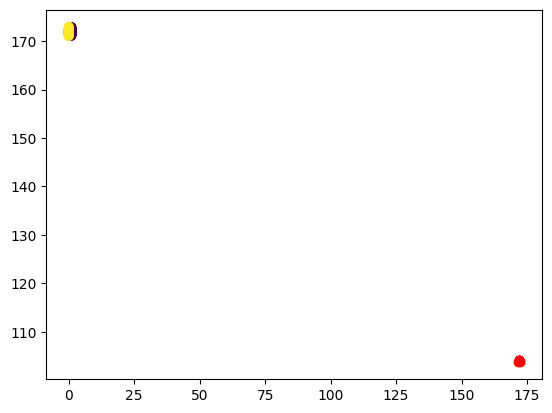

In [ ]:
plt.scatter(X[:,0], X[:,1], c=kmeans.predict(X_df))
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], c='r')

## On représente les cluster dans un dataframe

In [ ]:
# Récupérer les étiquettes des clusters
labels = kmeans.labels_

In [ ]:
# Mapper chaque cluster à une lettre de l'alphabet
cluster_to_letter = {0: 'A', 1: 'B'}

In [ ]:
# Assigner les lettres aux points de données
labels_mapped = np.array([cluster_to_letter[label] for label in labels])

In [ ]:
# Créer un DataFrame avec les données originales et les étiquettes mappées
df = pd.DataFrame(X_df)
df['Cluster'] = labels_mapped
df

,1,2,3,4,5,6,Cluster
0,171.81,104.86,104.95,4.52,2.89,112.83,A
1,171.46,103.36,103.66,3.77,2.99,113.09,A
2,172.69,104.48,103.5,4.4,2.94,113.16,A
3,171.36,103.91,103.94,3.62,3.01,113.51,A
4,171.73,104.28,103.46,4.04,3.48,112.54,A
...,...,...,...,...,...,...,...
1458,171.75,104.38,104.17,4.42,3.09,111.28,B
1459,172.19,104.63,104.44,5.27,3.37,110.97,B
1460,171.8,104.01,104.12,5.51,3.36,111.95,B
1461,172.06,104.28,104.06,5.17,3.46,112.25,B


# Test du jeu de données



In [ ]:
fichier_de_test = pd.read_csv('/content/drive/MyDrive/Openclassrooms/Colab Notebooks/Projet 10/Données de base/billets_production.csv')
fichier_de_test

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


## Test du jeu de donnée : Kmeans

In [ ]:
# On extrait seulement les valeurs numériques du dataframe sous forme d'array numpy :
X_test_kmeans = fichier_de_test.values
X_test_kmeans

array([[171.76, 104.01, 103.54, 5.21, 3.3, 111.42, 'A_1'],
       [171.87, 104.17, 104.13, 6.0, 3.31, 112.09, 'A_2'],
       [172.0, 104.58, 104.29, 4.99, 3.39, 111.57, 'A_3'],
       [172.49, 104.55, 104.34, 4.44, 3.03, 113.2, 'A_4'],
       [171.65, 103.63, 103.56, 3.77, 3.16, 113.33, 'A_5']], dtype=object)

In [ ]:
# On peut le transformer en DataFrame :
X_df_test_kmeans = pd.DataFrame(X_test_kmeans)

In [ ]:
X_df_test_kmeans


,0,1,2,3,4,5,6
0,171.76,104.01,103.54,5.21,3.3,111.42,A_1
1,171.87,104.17,104.13,6.0,3.31,112.09,A_2
2,172.0,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.2,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [ ]:
# On élimine les colonnes non numériques

X_df_test_kmeans = X_df_test_kmeans.drop(X_df.columns[[5]], axis=1)
X_df_test_kmeans

,0,1,2,3,4,5
0,171.76,104.01,103.54,5.21,3.3,111.42
1,171.87,104.17,104.13,6.0,3.31,112.09
2,172.0,104.58,104.29,4.99,3.39,111.57
3,172.49,104.55,104.34,4.44,3.03,113.2
4,171.65,103.63,103.56,3.77,3.16,113.33


In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X_df_test_kmeans)
x_scaled

array([[-0.66422777, -0.50222407, -1.22890038,  0.43822393,  0.48568108,
        -1.12401394],
       [-0.28760378, -0.0507867 ,  0.44945894,  1.4937023 ,  0.56401673,
        -0.28910336],
       [ 0.15749731,  1.10602155,  0.90460723,  0.14429325,  1.19070199,
        -0.93709366],
       [ 1.83518602,  1.02137704,  1.04684107, -0.59053347, -1.62938167,
         1.09410669],
       [-1.04085177, -1.57438781, -1.17200685, -1.48568601, -0.61101813,
         1.25610427]])

In [ ]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_df_test_kmeans)

KMeans(n_clusters=2)

## On représente les cluster dans un dataframe

In [ ]:
# Récupérer les étiquettes des clusters
labels = kmeans.labels_

In [ ]:
# Mapper chaque cluster à une lettre de l'alphabet
cluster_to_letter = {0: 'A', 1: 'B'}

In [ ]:
# Assigner les lettres aux points de données
labels_mapped = np.array([cluster_to_letter[label] for label in labels])


In [ ]:
# Créer un DataFrame avec les données originales et les étiquettes mappées
df = pd.DataFrame(X_df_test_kmeans)
df['Cluster'] = labels_mapped
df

,0,1,2,3,4,5,Cluster
0,171.76,104.01,103.54,5.21,3.3,111.42,A
1,171.87,104.17,104.13,6.0,3.31,112.09,A
2,172.0,104.58,104.29,4.99,3.39,111.57,A
3,172.49,104.55,104.34,4.44,3.03,113.2,B
4,171.65,103.63,103.56,3.77,3.16,113.33,B


## Test  du jeu de donnée : régression logistique

In [ ]:
billets = pd.read_csv('/content/drive/MyDrive/Openclassrooms/Colab Notebooks/Projet 10/Données de test - Régression logistique/billets_complete.csv',index_col = 'Unnamed: 0')
billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.520000,2.89,112.83
1,True,171.46,103.36,103.66,3.770000,2.99,113.09
2,True,172.69,104.48,103.50,4.400000,2.94,113.16
3,True,171.36,103.91,103.94,3.620000,3.01,113.51
4,True,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1303,False,172.17,104.49,103.76,5.305269,2.93,111.21
1315,False,172.08,104.15,104.17,5.205657,3.40,112.29
1347,False,171.72,104.46,104.12,5.161149,3.61,110.31
1435,False,172.66,104.33,104.41,5.171746,3.56,111.47


In [ ]:
fichier_de_test

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [ ]:
# On récupère les nom de colonnes à appliquer ensuite à nos données du df "X_df_test_log_regression".
column_name_X_test_log_regression = ['diagonal','height_left','height_right','margin_low','margin_up','length','id']
column_name_X_test_log_regression



['diagonal',
 'height_left',
 'height_right',
 'margin_low',
 'margin_up',
 'length',
 'id']

In [ ]:
# # On extrait seulement les valeurs numériques du dataframe sous forme d'array numpy

X_test_log_regression = fichier_de_test.values
X_df_test_log_regression = pd.DataFrame(X_test_log_regression)

In [ ]:
X_df_test_log_regression

,0,1,2,3,4,5,6
0,171.76,104.01,103.54,5.21,3.3,111.42,A_1
1,171.87,104.17,104.13,6.0,3.31,112.09,A_2
2,172.0,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.2,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [ ]:
# Application des nouveaux noms de colonnes au DataFrame
X_df_test_log_regression.columns = column_name_X_test_log_regression

In [ ]:
X_df_test_log_regression

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.3,111.42,A_1
1,171.87,104.17,104.13,6.0,3.31,112.09,A_2
2,172.0,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.2,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [ ]:
X_df_test_log_regression.set_index('id', inplace=True)
X_df_test_log_regression

,diagonal,height_left,height_right,margin_low,margin_up,length
id,,,,,,
A_1,171.76,104.01,103.54,5.21,3.3,111.42
A_2,171.87,104.17,104.13,6.0,3.31,112.09
A_3,172.0,104.58,104.29,4.99,3.39,111.57
A_4,172.49,104.55,104.34,4.44,3.03,113.2
A_5,171.65,103.63,103.56,3.77,3.16,113.33


In [ ]:
billets = pd.read_csv('/content/billets_complete.csv',index_col = 'Unnamed: 0')
billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.520000,2.89,112.83
1,True,171.46,103.36,103.66,3.770000,2.99,113.09
2,True,172.69,104.48,103.50,4.400000,2.94,113.16
3,True,171.36,103.91,103.94,3.620000,3.01,113.51
4,True,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1303,False,172.17,104.49,103.76,5.047570,2.93,111.21
1315,False,172.08,104.15,104.17,4.778967,3.40,112.29
1347,False,171.72,104.46,104.12,5.726993,3.61,110.31
1435,False,172.66,104.33,104.41,5.185862,3.56,111.47


In [ ]:
def detection_faux_billets(nom_fichier_csv):
    # Nous avons récupéré notre fichier, précédemment créé qui a été enregistré dans la mémoire de google collab.
    billets = pd.read_csv('/content/billets_complete.csv',index_col = 'Unnamed: 0')
    variables = billets.columns.drop('is_genuine')
    data = billets[variables]
    target = billets['is_genuine']
    atester2 = pd.read_csv('/content/drive/MyDrive/Openclassrooms/Colab Notebooks/Projet 10/Exam - Fichier test /billets_test .csv')   # Fichier à modifier pour le test
    modele_logit = LogisticRegression(penalty='none', solver='newton-cg')
    modele_logit.fit(data.drop(columns=['diagonal', 'height_right']), target)  # On utilise les données complétées par régression linéaire, centrée et réduite pour entraîner le modèle.
    atester2['is_genuine'] = modele_logit.predict(
        atester2[variables].drop(columns=['diagonal', 'height_right']))
    atester2[['Proba False', 'Proba True']] = modele_logit.predict_proba(
        atester2[variables].drop(columns=['diagonal', 'height_right']))
    return atester2[['is_genuine','Proba False','Proba True']]

# Si le code ne fonctionne pas : corriger avec ça --> return atester2[['id', 'is_genuine','Proba False','Proba True']]

In [ ]:
detection_faux_billets('/content/drive/MyDrive/Openclassrooms/Colab Notebooks/Projet 10/Exam - Fichier test /billets_test .csv')

,is_genuine,Proba False,Proba True
0,True,0.001192,9.988076e-01
1,False,0.999732,2.679918e-04
2,True,0.000034,9.999658e-01
3,False,1.000000,1.559845e-07
4,False,0.996893,3.107070e-03
